In [3]:
# install required packages

# ! pip install -r requirements.txt

To recreate this analysis, please reference the requirements.txt file.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.stats.outliers_influence as smoi

from autogluon.tabular import TabularPredictor
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from transformers import DistilBertModel, DistilBertTokenizer
from verstack import LGBMTuner



In [5]:
df = pd.read_csv('askscience_data.csv')
df.head()

Unnamed: 0                                              title  \
0           0  Post viral cough: why does it get worse after ...   
1           1  Can an x-ray of an adult show chronic malnouri...   
2           2           [META] Bots and AI tools on r/askscience   
3           3     Can you predictably manipulate a magnetic gas?   
4           4  Are there cells in humans (or other mammals) t...   

                                                body         tag  \
0  Tl;dr: why is your cough during an upper respi...  Human Body   
1  If a person was chronically undernourished thr...  Human Body   
2   \n\nOver the past few days we have seen a sur...        META   
3  Does there exist a gas that changes in respons...     Physics   
4                                                NaN    Medicine   

              datetime                author   score  upvote_ratio  \
0  2022-12-09 02:52:07    CarboniferousCreek  1343.0          0.93   
1  2022-12-08 18:28:51  Foxs-In-A-Trenchcoat   426.0          0.91   
2  2022-12-08 09:04:25   AskScienceModerator  2218.0          0.92   
3  2022-12-08 20:01:53                hufsa7    48.0          0.83   
4  2022-12-09 01:11:34                 Velym    14.0          0.89   

                                                 url  
0  https://www.reddit.com/r/askscience/comments/z...  
1  https://www.reddit.com/r/askscience/comments/z...  
2  https://www.reddit.com/r/askscience/comments/z...  
3  https://www.reddit.com/r/askscience/comments/z...  
4  https://www.reddit.com/r/askscience/comments/z...

Check what is in the Unnamed: 0 column

In [6]:
df.loc[df["Unnamed: 0"] == 255]

Unnamed: 0                                              title  \
255          255  From my kid: Can you put a marshmallow on a st...   
2877         255  Does Acid Rain still happen in the United Stat...   

                                                   body             tag  \
255   I assume the answer is yes, given the heat of ...         Physics   
2877                                                NaN  Earth Sciences   

                 datetime        author    score  upvote_ratio  \
255   2017-11-21 18:31:54  StuckInAPuma  11260.0          0.86   
2877  2019-04-14 07:09:11         3oons  10742.0          0.94   

                                                    url  
255   https://www.reddit.com/r/askscience/comments/7...  
2877  https://www.reddit.com/r/askscience/comments/b...

In [7]:
print(f"Length of Unnamed: 0 {df['Unnamed: 0'].nunique()} vs. the shape of the dataframe rows {df.shape[0]}")


Length of Unnamed: 0 2732 vs. the shape of the dataframe rows 4205


Since the Unnamed column share index results and those respective posts seem to unrelated in user, score etc I will drop the column and use the index inferred by pandas on when I read in the CSV.

In [8]:
df = df.drop(columns=['Unnamed: 0'])

In [9]:
# Does URL matter?
df['url'].nunique()

# show the shared URLS that repeat more than once
url_values = df['url'].value_counts()
url_values = url_values[url_values > 1]
url_values

https://www.reddit.com/r/askscience/comments/gtdmys/what_is_the_diameter_of_a_lightning_they_are/         2
https://www.reddit.com/r/askscience/comments/5t7b51/what_is_the_smallest_amount_of_matter_needed_to/      2
https://www.reddit.com/r/askscience/comments/hgttpt/how_can_medicines_like_ibuprofen_and/                 2
https://www.reddit.com/r/askscience/comments/8gw1g2/when_the_mars_rover_went_to_mars_were_they_able/      2
https://www.reddit.com/r/askscience/comments/7pw56k/why_can_completely_paralyzed_people_often_blink/      2
                                                                                                         ..
https://www.reddit.com/r/askscience/comments/9s48sm/whats_the_difference_between_me_thinking_about/       2
https://www.reddit.com/r/askscience/comments/7mmz8i/why_do_computers_and_game_consoles_need_to/           2
https://www.reddit.com/r/askscience/comments/io8zax/when_someone_has_cancer_they_typically_lose_a_lot/    2
https://www.reddit.com/r/ask

In [10]:
# for the urls that are repeated, are the rows the same?

for url in url_values.index:
    print(df.loc[df['url'] == url])

                                                  title body             tag  \
648   What is the diameter of a lightning? They are ...  NaN  Earth Sciences   
3052  What is the diameter of a lightning? They are ...  NaN  Earth Sciences   

                 datetime    author   score  upvote_ratio  \
648   2020-05-30 05:39:05  fmorenol  7852.0          0.95   
3052  2020-05-30 05:39:05  fmorenol  7852.0          0.95   

                                                    url  
648   https://www.reddit.com/r/askscience/comments/g...  
3052  https://www.reddit.com/r/askscience/comments/g...  
                                                  title body      tag  \
540   What is the smallest amount of matter needed t...  NaN  Physics   
3001  What is the smallest amount of matter needed t...  NaN  Physics   

                 datetime   author   score  upvote_ratio  \
540   2017-02-10 05:40:39  vangyyy  8493.0          0.89   
3001  2017-02-10 05:40:39  vangyyy  8496.0          0.89   



In [11]:
# drop duplicates and check again

df = df.drop_duplicates(subset=['url'])

url_values = df['url'].value_counts()
url_values = url_values[url_values > 1]
url_values

Series([], Name: url, dtype: int64)

Additionally, given the that URL is inherently unique, and the user essentally does not interact with the URL, I will drop the URL column as well.

# Explore the data

In [12]:
df

title  \
0     Post viral cough: why does it get worse after ...   
1     Can an x-ray of an adult show chronic malnouri...   
2              [META] Bots and AI tools on r/askscience   
3        Can you predictably manipulate a magnetic gas?   
4     Are there cells in humans (or other mammals) t...   
...                                                 ...   
4200  I heard some electron microscopes use gallium....   
4201  is the spread of COVID typical for a respirato...   
4202  What is the technical difference between Cheek...   
4203  What starts the coagulation cascade during blo...   
4204  Does the light/energy radiate from the sun at ...   

                                                   body          tag  \
0     Tl;dr: why is your cough during an upper respi...   Human Body   
1     If a person was chronically undernourished thr...   Human Body   
2      \n\nOver the past few days we have seen a sur...         META   
3     Does there exist a gas that changes in respons...      Physics   
4                                                   NaN     Medicine   
...                                                 ...          ...   
4200                                                NaN  Engineering   
4201  i understand that there's no respiratory virus...     COVID-19   
4202  What are the technical difference(s) between t...     COVID-19   
4203  I understand that stasis of blood increases th...   Human Body   
4204                                                NaN    Astronomy   

                 datetime                author   score  upvote_ratio  \
0     2022-12-09 02:52:07    CarboniferousCreek  1343.0          0.93   
1     2022-12-08 18:28:51  Foxs-In-A-Trenchcoat   426.0          0.91   
2     2022-12-08 09:04:25   AskScienceModerator  2218.0          0.92   
3     2022-12-08 20:01:53                hufsa7    48.0          0.83   
4     2022-12-09 01:11:34                 Velym    14.0          0.89   
...                   ...                   ...     ...           ...   
4200  2022-01-12 17:14:35           Emma_Dale20     6.0          0.70   
4201  2022-01-12 09:39:55              aggasalk    27.0          0.74   
4202  2022-01-12 14:47:28              h110hawk     3.0          0.67   
4203  2022-01-12 14:20:26          joegoldbergg     5.0          0.78   
4204  2022-01-11 08:14:49               trinerr   693.0          0.93   

                                                    url  
0     https://www.reddit.com/r/askscience/comments/z...  
1     https://www.reddit.com/r/askscience/comments/z...  
2     https://www.reddit.com/r/askscience/comments/z...  
3     https://www.reddit.com/r/askscience/comments/z...  
4     https://www.reddit.com/r/askscience/comments/z...  
...                                                 ...  
4200  https://www.reddit.com/r/askscience/comments/s...  
4201  https://www.reddit.com/r/askscience/comments/s...  
4202  https://www.reddit.com/r/askscience/comments/s...  
4203  https://www.reddit.com/r/askscience/comments/s...  
4204  https://www.reddit.com/r/askscience/comments/s...  

[3707 rows x 8 columns]

# How many posts are missing tags?

In [13]:
missing_tags = df['tag'].isna().sum()
print(f"Number of posts missing tags: {missing_tags}")

Number of posts missing tags: 194


In [14]:
# Let's create a new tag titles missing. Then we can assess performance later.

df['tag'] = df['tag'].fillna('missing')


In [15]:
# check the distrubtions of the tags

tag_distribution = df['tag'].value_counts()
tag_distribution

Biology                        630
Physics                        561
Human Body                     387
Medicine                       302
Earth Sciences                 271
Astronomy                      236
Chemistry                      207
missing                        194
COVID-19                       188
Engineering                    161
Neuroscience                    98
Planetary Sci.                  98
Mathematics                     92
Psychology                      83
Computing                       48
Paleontology                    43
Linguistics                     27
Social Science                  20
Anthropology                    18
Economics                       14
Archaeology                     14
Interdisciplinary                3
  Linguistics                    2
Meta                             1
Political Science                1
Materials Science                1
Dog Cognition AMA                1
Earth Sciences and Biology       1
CERN AMA            

We see a large number of categories are small in size. This is a problem for our analysis as we will not have enough data to train a model on. We will need to combine some of the smaller categories into a larger categories

In [16]:
tag_categories = {
    'Natural Sciences': ['Biology', 'Physics', 'Earth Sciences', 'Astronomy', 'Chemistry'],
    'Health and Medicine': ['Human Body', 'Medicine', 'COVID-19', 'Neuroscience'],
    'Social Sciences': ['Psychology', 'Social Science', 'Anthropology', 'Economics', 'Political Science'],
    'Mathematics': ['Mathematics'],
    'Computing and Technology': ['Computing', 'Engineering'],
    'Paleontology and Archaeology': ['Paleontology', 'Archaeology'],
    'Language and Linguistics': ['Linguistics'],
    'Other': ["Interdisciplinary",'missing',"Meta", 'Planetary Sci.', 'First image of a black hole', 'Dog Cognition AMA', 'CERN AMA', 'Ecology', 'Food']
}

df["tag_category"] = np.nan

for category, tags in tag_categories.items():
    df.loc[df['tag'].isin(tags), 'tag_category'] = category
    
df['tag_category'].value_counts()


Natural Sciences                1905
Health and Medicine              975
Other                            301
Computing and Technology         209
Social Sciences                  136
Mathematics                       92
Paleontology and Archaeology      57
Language and Linguistics          27
Name: tag_category, dtype: int64

While stll unbalanced this is a better starting point for fitting a model. Ultimatley we will see if this feature helps or is a unhelpful to our model.

# Does the number of posts an author makes matter? Does the subreddit follow specific authors?

We will explore with correlation is author post count and score is correlated

In [17]:
df["author_num_posts"] = df.groupby("author")["author"].transform("count")

In [18]:
df.sort_values(by=['score'], ascending=False).head(10)

title  \
25                  Help us fight for net neutrality!   
26                         Stephen Hawking megathread   
27                                 Black Lives Matter   
28                             A message to our users   
29  Why is it that during winter it's not uncommon...   
30  If we could travel at 99.9% the speed of light...   
31  Do giraffes get struck by lightning more often...   
32  What % of my weight am I actually lifting when...   
33  What is the point of using screws with a Phill...   
34  If hand sanitizer kills 99.99% of germs, then ...   

                                                 body             tag  \
25  The ability to browse the internet is at risk....         missing   
26  We were sad to learn that noted physicist, cos...         Physics   
27  **Black lives matter.** The moderation team at...  Social Science   
28  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Today in AskScie...            Meta   
29                          I live in the USA Midwest  Earth Sciences   
30                                                NaN         Physics   
31                                                NaN         Biology   
32                                                NaN         Physics   
33                                                NaN     Engineering   
34                                                NaN         Biology   

               datetime               author    score  upvote_ratio  \
25  2017-11-22 11:38:53            MockDeath  83382.0          0.78   
26  2018-03-13 22:03:48  AskScienceModerator  65835.0          0.85   
27  2020-06-02 10:57:46  AskScienceModerator  51927.0          0.68   
28  2015-07-02 19:43:47            MockDeath  39288.0          0.86   
29  2018-02-20 08:23:37      This31415926535  37681.0          0.87   
30  2019-01-20 06:57:37                GPL89  34357.0          0.91   
31  2017-03-29 08:25:25              DELETED  32564.0          0.90   
32  2017-10-26 11:25:46         Standby4Rant  32346.0          0.90   
33  2017-05-27 12:59:49            EthanNewb  31423.0          0.89   
34  2017-10-11 07:00:21              ClF3FTW  28887.0          0.81   

                                                  url  \
25  https://www.reddit.com/r/askscience/comments/7...   
26  https://www.reddit.com/r/askscience/comments/8...   
27  https://www.reddit.com/r/askscience/comments/g...   
28  https://www.reddit.com/r/askscience/comments/3...   
29  https://www.reddit.com/r/askscience/comments/7...   
30  https://www.reddit.com/r/askscience/comments/a...   
31  https://www.reddit.com/r/askscience/comments/6...   
32  https://www.reddit.com/r/askscience/comments/7...   
33  https://www.reddit.com/r/askscience/comments/6...   
34  https://www.reddit.com/r/askscience/comments/7...   

                tag_category  author_num_posts  
25                     Other                 2  
26          Natural Sciences                47  
27           Social Sciences                47  
28                     Other                 2  
29          Natural Sciences                 1  
30          Natural Sciences                 1  
31          Natural Sciences               216  
32          Natural Sciences                 1  
33  Computing and Technology                 1  
34          Natural Sciences                 1

In [19]:
df[["score", "upvote_ratio", "author_num_posts"]].corr()

score  upvote_ratio  author_num_posts
score             1.000000      0.510127          0.038453
upvote_ratio      0.510127      1.000000         -0.090872
author_num_posts  0.038453     -0.090872          1.000000

In [20]:
px.scatter(df, x='author_num_posts', y='score', trendline='ols')

We can say that an author that posts often does not mean that the post will be popular. In fact majority of the top 10 scoring posts are not by repeat authors. Additionally as we see in the graph the three distinct group have a wide range of scores. I will keep the feature in the data for now, but do not expect this to have a large impact on the model.

Additionally, we will remove author from the dataframe, as this not a feature that we will use for any further EDA or feature generation


In [21]:

df = df.drop(columns=['author'])

# Body Features

In [22]:
# get missing count
df["body"].isna().sum()

1216

About a quarter of the posts have no body. I will add a column called no body and assign 1 if there is no body and 0 if there is a body.

Then fill the NaN values with a space so that the tokenizer does not throw an error.

In [23]:
df["empty_body"] = df.apply(lambda row: 1 if pd.isna(row["body"]) else 0, axis=1)

In [24]:
df["body"] = df["body"].fillna("")

## Get sentiment of the body and subjectivity

In [25]:
# get the sentiment of the body


df['body_polarity'] = df['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['body_polarity'].describe()





count    3707.000000
mean        0.051095
std         0.148985
min        -0.800000
25%         0.000000
50%         0.000000
75%         0.109484
max         1.000000
Name: body_polarity, dtype: float64

In [26]:
df["body_subjectivity"] = df['body'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['body_subjectivity'].describe()

count    3707.000000
mean        0.292470
std         0.265814
min         0.000000
25%         0.000000
50%         0.333333
75%         0.500000
max         1.000000
Name: body_subjectivity, dtype: float64

For context:  Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment. Subjectivity lies between [0,1], where 0 defines a fact and 1 defines a very subjective view.

I will leave them as a numeric feature so the model can potentially learn so nuance of the values between -1,0,1. For example -.25

In [27]:
# word count of the body

df['body_word_count'] = df['body'].apply(lambda x: len(x.split()))


# Title Features

In [28]:
# how many titles are null

df["title"].isnull().sum()

0

No missing titles. Likely a feature of Reddit requiring a title.

In [29]:
# build feature for length of title

df["length_title"] = df["title"].apply(lambda x: len(x.split()))

## Get sentiment of the title and subjectivity as we built them for body also

In [30]:
# title polarity

df["title_polarity"] = df["title"].apply(lambda x: TextBlob(x).sentiment.polarity)

df["title_polarity"].describe()

count    3707.000000
mean        0.047784
std         0.198872
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.116667
max         1.000000
Name: title_polarity, dtype: float64

In [31]:
df["title_subjectivity"] = df["title"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

df["title_subjectivity"].describe()

count    3707.000000
mean        0.306769
std         0.288248
min         0.000000
25%         0.000000
50%         0.300000
75%         0.500000
max         1.000000
Name: title_subjectivity, dtype: float64

# Additional Features: Reading Level

I will use, Flesch-Kincaid Grade Level as its more international and likely reddit users are from all over the world


In [32]:
# Readability Metrics:

import textstat

df["title_fk"] = df["title"].apply(lambda x: textstat.flesch_kincaid_grade(x))
df["body_fk"] = df["body"].apply(lambda x: textstat.flesch_kincaid_grade(x))

df
 

title  \
0     Post viral cough: why does it get worse after ...   
1     Can an x-ray of an adult show chronic malnouri...   
2              [META] Bots and AI tools on r/askscience   
3        Can you predictably manipulate a magnetic gas?   
4     Are there cells in humans (or other mammals) t...   
...                                                 ...   
4200  I heard some electron microscopes use gallium....   
4201  is the spread of COVID typical for a respirato...   
4202  What is the technical difference between Cheek...   
4203  What starts the coagulation cascade during blo...   
4204  Does the light/energy radiate from the sun at ...   

                                                   body          tag  \
0     Tl;dr: why is your cough during an upper respi...   Human Body   
1     If a person was chronically undernourished thr...   Human Body   
2      \n\nOver the past few days we have seen a sur...         META   
3     Does there exist a gas that changes in respons...      Physics   
4                                                           Medicine   
...                                                 ...          ...   
4200                                                     Engineering   
4201  i understand that there's no respiratory virus...     COVID-19   
4202  What are the technical difference(s) between t...     COVID-19   
4203  I understand that stasis of blood increases th...   Human Body   
4204                                                       Astronomy   

                 datetime   score  upvote_ratio  \
0     2022-12-09 02:52:07  1343.0          0.93   
1     2022-12-08 18:28:51   426.0          0.91   
2     2022-12-08 09:04:25  2218.0          0.92   
3     2022-12-08 20:01:53    48.0          0.83   
4     2022-12-09 01:11:34    14.0          0.89   
...                   ...     ...           ...   
4200  2022-01-12 17:14:35     6.0          0.70   
4201  2022-01-12 09:39:55    27.0          0.74   
4202  2022-01-12 14:47:28     3.0          0.67   
4203  2022-01-12 14:20:26     5.0          0.78   
4204  2022-01-11 08:14:49   693.0          0.93   

                                                    url  \
0     https://www.reddit.com/r/askscience/comments/z...   
1     https://www.reddit.com/r/askscience/comments/z...   
2     https://www.reddit.com/r/askscience/comments/z...   
3     https://www.reddit.com/r/askscience/comments/z...   
4     https://www.reddit.com/r/askscience/comments/z...   
...                                                 ...   
4200  https://www.reddit.com/r/askscience/comments/s...   
4201  https://www.reddit.com/r/askscience/comments/s...   
4202  https://www.reddit.com/r/askscience/comments/s...   
4203  https://www.reddit.com/r/askscience/comments/s...   
4204  https://www.reddit.com/r/askscience/comments/s...   

                  tag_category  author_num_posts  empty_body  body_polarity  \
0          Health and Medicine                 1           0      -0.071049   
1          Health and Medicine                 2           0       0.175000   
2                          NaN                47           0       0.063750   
3             Natural Sciences                 1           0       0.034921   
4          Health and Medicine                 1           1       0.000000   
...                        ...               ...         ...            ...   
4200  Computing and Technology                 2           1       0.000000   
4201       Health and Medicine                 2           0       0.022959   
4202       Health and Medicine                 1           0       0.003333   
4203       Health and Medicine                 1           0      -0.041667   
4204          Natural Sciences                 2           1       0.000000   

      body_subjectivity  body_word_count  length_title  title_polarity  \
0              0.531746              272            12        0.050000   
1              0.500000               40            11   

Lets look into average tokenization as a way to create a numerical representation of the texts for the initial models I will look at an average. I would rather utilize the full vector but for this first modeling attempt I will use the average.

In [33]:
# Combine title and body into a single text column
df['text'] = df['title'] + ' ' + df['body']

# Word2Vec Embeddings
tokenized_text = [word_tokenize(sentence.lower()) for sentence in df['text']]
word2vec_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, sg=0)
word2vec_model.train(tokenized_text, total_examples=len(tokenized_text), epochs=10)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])


In [34]:
df['text'] = df['title'] + ' ' + df['body']

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
average_tfidf_values = tfidf_matrix.mean(axis=1)
df['average_tfidf'] = average_tfidf_values

In [35]:
df['text'] = df['title'] + ' ' + df['body']

tokenized_text = [word_tokenize(sentence.lower()) for sentence in df['text']]

word2vec_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, sg=0)
word2vec_model.train(tokenized_text, total_examples=len(tokenized_text), epochs=10)

averaged_word2vec_vectors = []

for tokens in tokenized_text:
    word_vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if word_vectors:
        averaged_vector = np.mean(word_vectors, axis=0)
        averaged_word2vec_vectors.append(averaged_vector)
    else:
        averaged_word2vec_vectors.append(np.zeros(100))  # Assuming vector_size is 100

average_word2vec = np.mean(averaged_word2vec_vectors, axis=0)




In [36]:
df['average_word2vec'] = averaged_word2vec_vectors
df["avg_word2vec"] = df["average_word2vec"].apply(lambda x: np.mean(x, axis=0))
df.drop(columns=['average_word2vec'], inplace=True)
df

title  \
0     Post viral cough: why does it get worse after ...   
1     Can an x-ray of an adult show chronic malnouri...   
2              [META] Bots and AI tools on r/askscience   
3        Can you predictably manipulate a magnetic gas?   
4     Are there cells in humans (or other mammals) t...   
...                                                 ...   
4200  I heard some electron microscopes use gallium....   
4201  is the spread of COVID typical for a respirato...   
4202  What is the technical difference between Cheek...   
4203  What starts the coagulation cascade during blo...   
4204  Does the light/energy radiate from the sun at ...   

                                                   body          tag  \
0     Tl;dr: why is your cough during an upper respi...   Human Body   
1     If a person was chronically undernourished thr...   Human Body   
2      \n\nOver the past few days we have seen a sur...         META   
3     Does there exist a gas that changes in respons...      Physics   
4                                                           Medicine   
...                                                 ...          ...   
4200                                                     Engineering   
4201  i understand that there's no respiratory virus...     COVID-19   
4202  What are the technical difference(s) between t...     COVID-19   
4203  I understand that stasis of blood increases th...   Human Body   
4204                                                       Astronomy   

                 datetime   score  upvote_ratio  \
0     2022-12-09 02:52:07  1343.0          0.93   
1     2022-12-08 18:28:51   426.0          0.91   
2     2022-12-08 09:04:25  2218.0          0.92   
3     2022-12-08 20:01:53    48.0          0.83   
4     2022-12-09 01:11:34    14.0          0.89   
...                   ...     ...           ...   
4200  2022-01-12 17:14:35     6.0          0.70   
4201  2022-01-12 09:39:55    27.0          0.74   
4202  2022-01-12 14:47:28     3.0          0.67   
4203  2022-01-12 14:20:26     5.0          0.78   
4204  2022-01-11 08:14:49   693.0          0.93   

                                                    url  \
0     https://www.reddit.com/r/askscience/comments/z...   
1     https://www.reddit.com/r/askscience/comments/z...   
2     https://www.reddit.com/r/askscience/comments/z...   
3     https://www.reddit.com/r/askscience/comments/z...   
4     https://www.reddit.com/r/askscience/comments/z...   
...                                                 ...   
4200  https://www.reddit.com/r/askscience/comments/s...   
4201  https://www.reddit.com/r/askscience/comments/s...   
4202  https://www.reddit.com/r/askscience/comments/s...   
4203  https://www.reddit.com/r/askscience/comments/s...   
4204  https://www.reddit.com/r/askscience/comments/s...   

                  tag_category  author_num_posts  empty_body  ...  \
0          Health and Medicine                 1           0  ...   
1          Health and Medicine                 2           0  ...   
2                          NaN                47           0  ...   
3             Natural Sciences                 1           0  ...   
4          Health and Medicine                 1           1  ...   
...                        ...               ...         ...  ...   
4200  Computing and Technology                 2           1  ...   
4201       Health and Medicine                 2           0  ...   
4202       Health and Medicine                 1           0  ...   
4203       Health and Medicine                 1           0  ...   
4204          Natural Sciences                 2           1  ...   

      body_subjectivity  body_word_count  length_title  title_polarity  \
0              0.531746              272            12        0.050000   
1              0.500000               40            11        0.100000   
2              0.589375               91             7        0.000000   
3              0.482540      

In [37]:
# cluster the posts based on all numerical features PCA
X = df[["upvote_ratio", "author_num_posts", "empty_body", "body_polarity", "body_subjectivity", "body_word_count", "length_title", "title_polarity", "title_subjectivity",
        "average_tfidf","avg_word2vec", "title_fk","body_fk"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

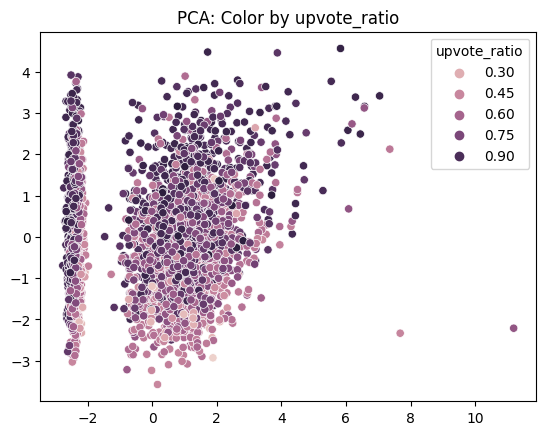

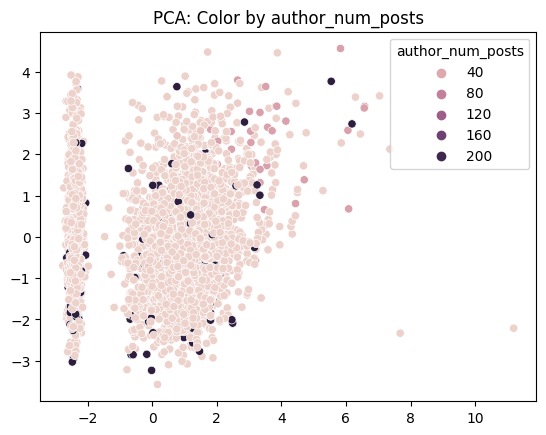

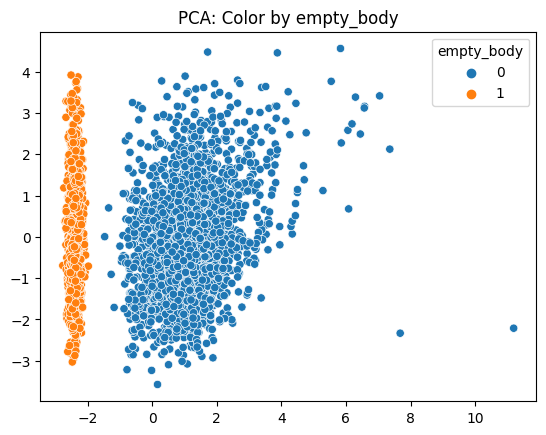

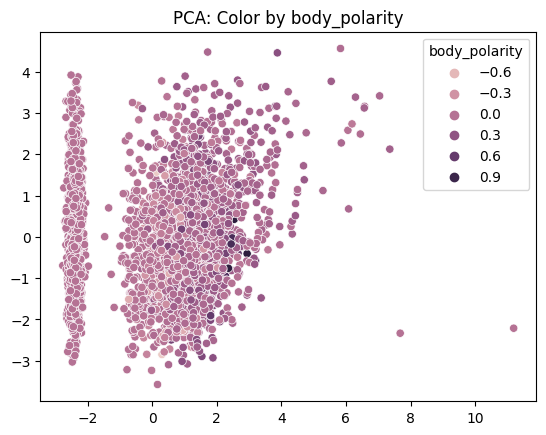

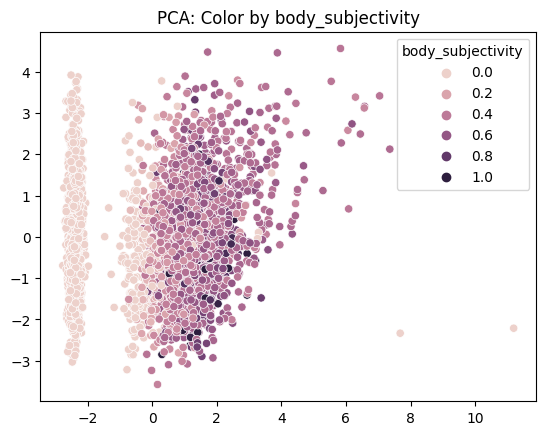

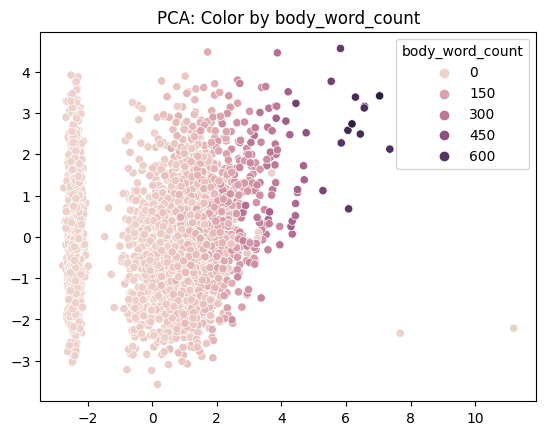

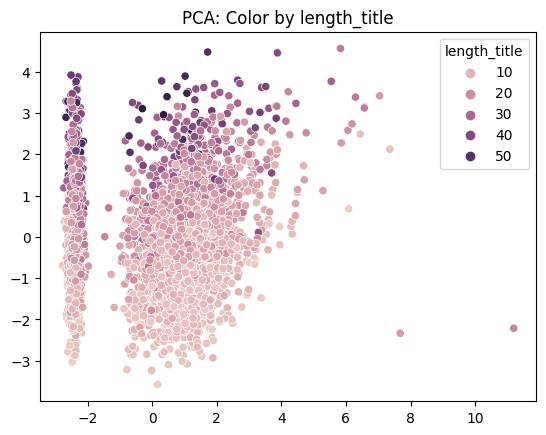

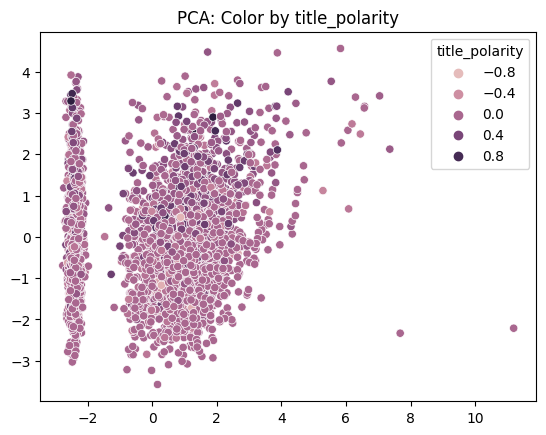

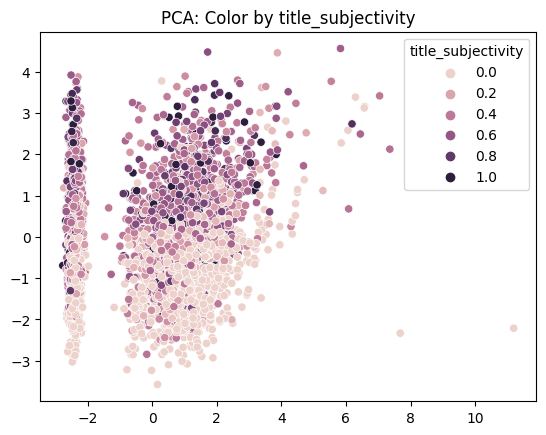

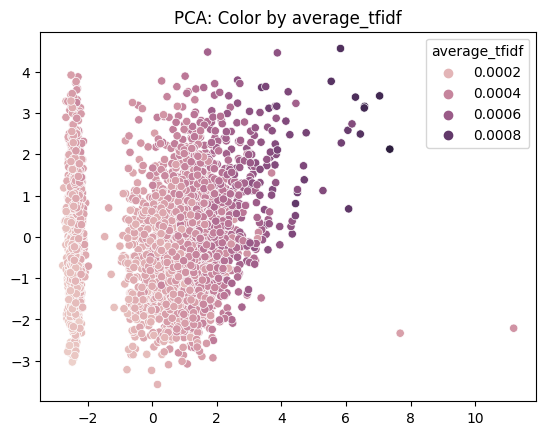

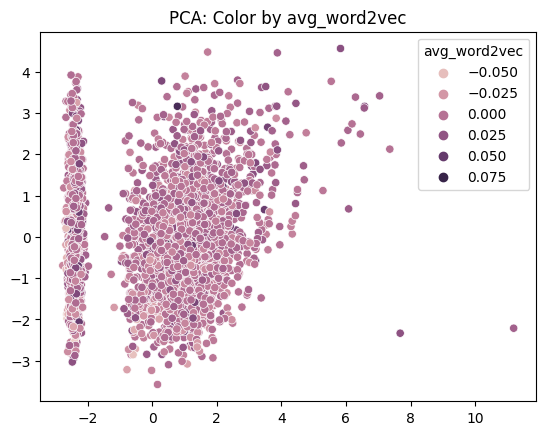

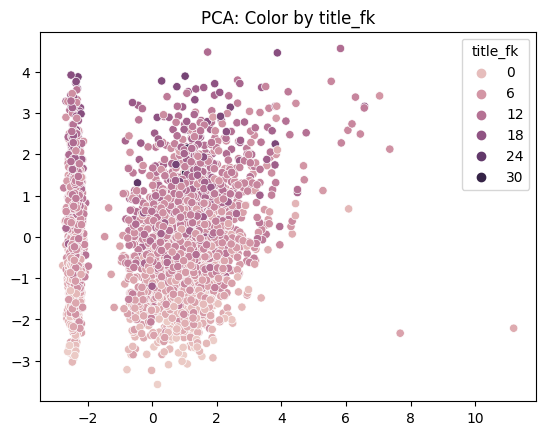

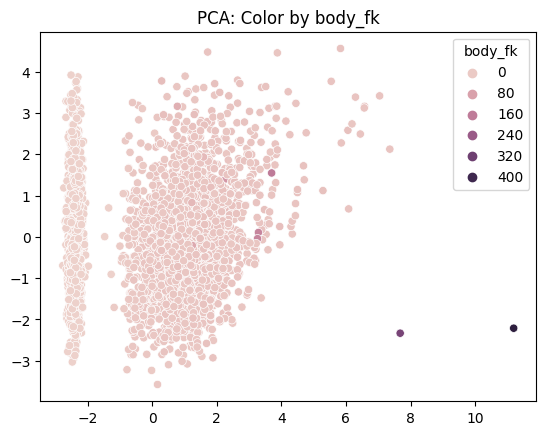

In [38]:
for col in X.columns:
    fig = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=X[col])
    # add a title
    fig.set_title(f"PCA: Color by {col}")
    plt.show()
    

we see 2 distinct clusters. that are perfectly seperated by our empty body flag. We will also check tsne to see if we can see any other clusters. 

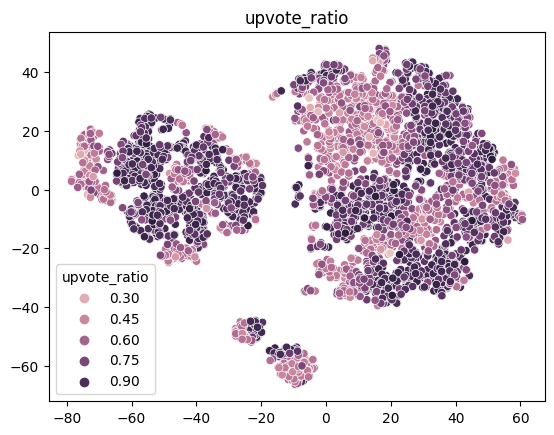

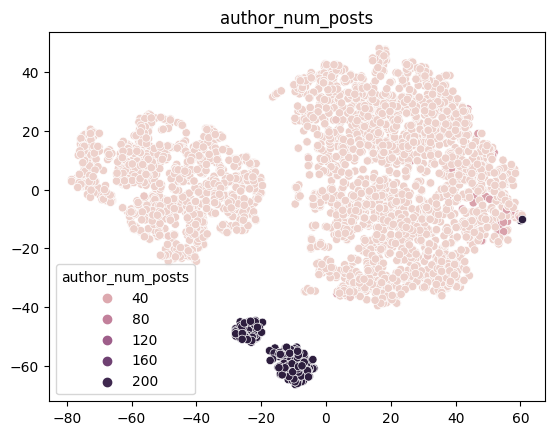

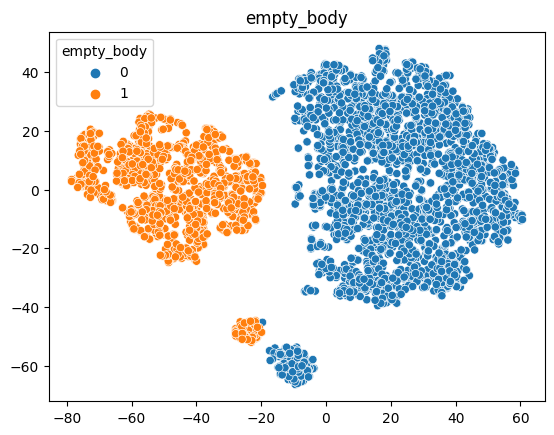

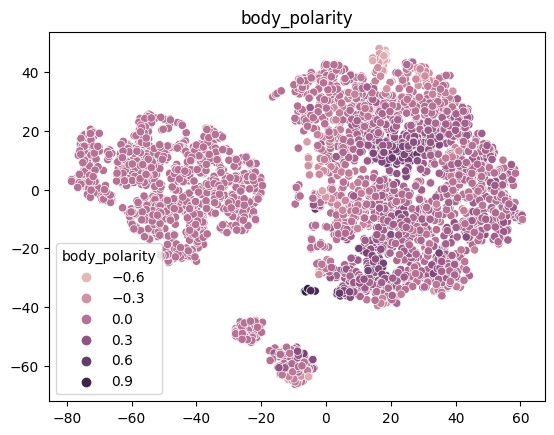

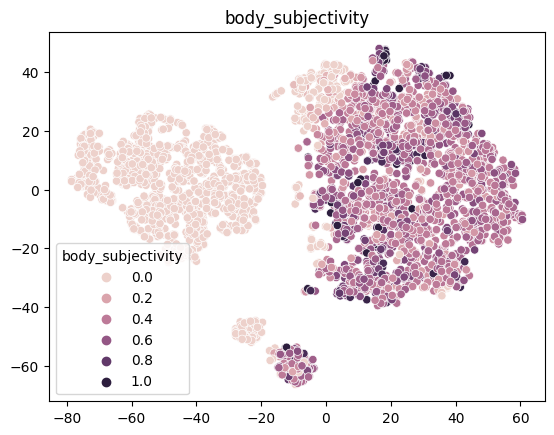

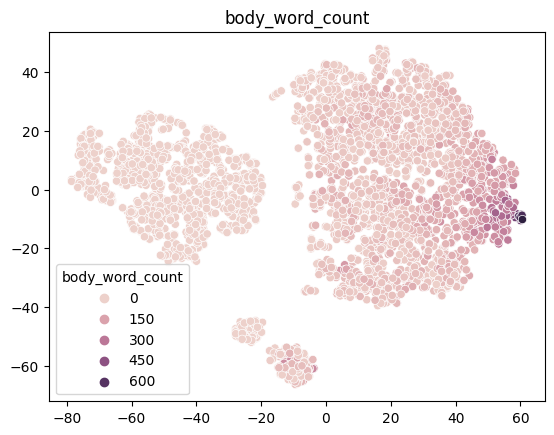

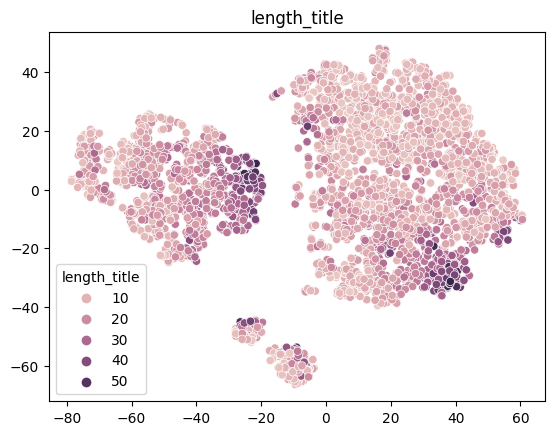

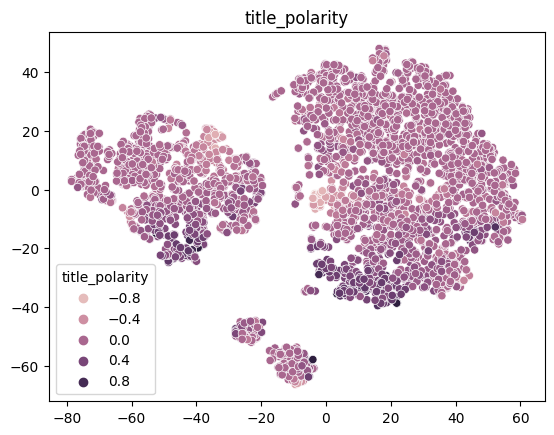

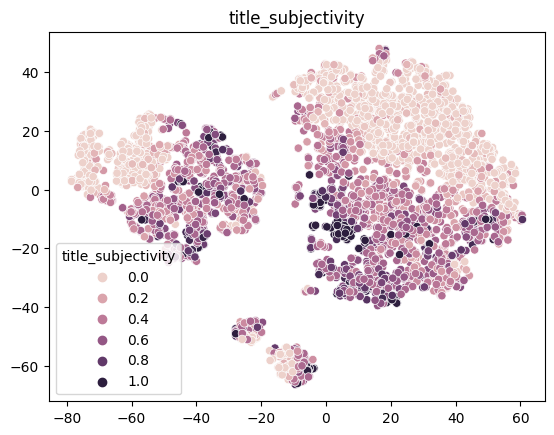

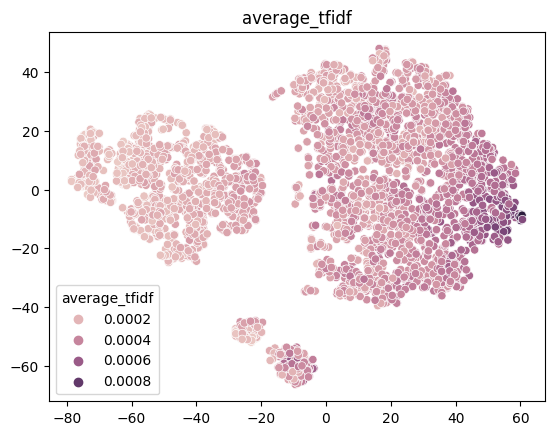

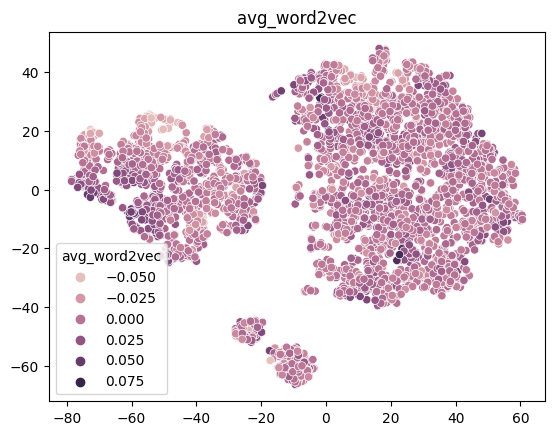

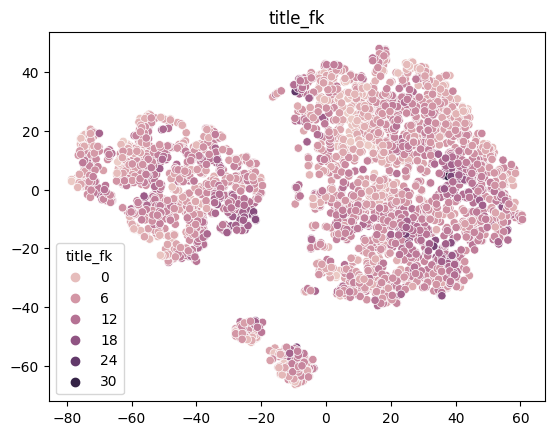

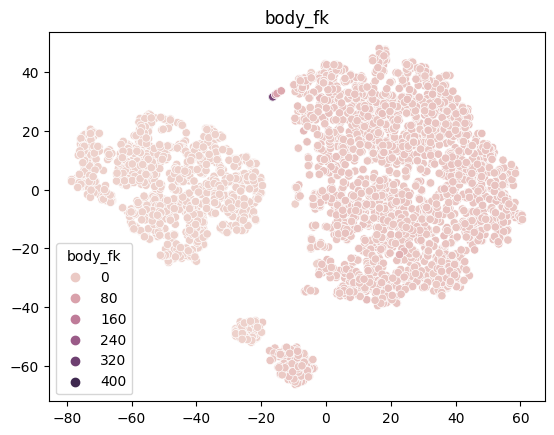

In [39]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

# plot the result clusters

for col in X.columns:
    fig = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=X[col])#, s=50, alpha=0.7)
    fig.set_title(col)
    plt.show()
    

# Modeling

In [40]:
from sklearn.model_selection import train_test_split

modeling_df = df[["upvote_ratio", "author_num_posts", "empty_body", "body_polarity", "body_subjectivity", "body_word_count", "length_title", "title_polarity", "title_subjectivity",
        "average_tfidf","avg_word2vec", "title_fk","body_fk","score","tag_category"]]

train, test = train_test_split(modeling_df, test_size=0.33, random_state=42)


upvote_ratio  author_num_posts  empty_body  body_polarity  \
1206          0.67                 1           0       0.000000   
509           0.95                 1           1       0.000000   
597           0.91                 1           1       0.000000   
1587          0.61                 1           0      -0.059821   
981           0.91                 1           0       0.000000   
...            ...               ...         ...            ...   
1130          0.71                 1           0       0.114286   
1294          0.82                 1           0       0.081771   
860           0.92                 1           0       0.050000   
4003          0.88                 1           0       0.083333   
3669          0.75                 1           0       0.009091   

      body_subjectivity  body_word_count  length_title  title_polarity  \
1206           0.000000                1            21        0.000000   
509            0.000000                0            23       -0.225000   
597            0.000000                0             9        0.068182   
1587           0.577266               53            12        0.000000   
981            0.000000                7            17        0.000000   
...                 ...              ...           ...             ...   
1130           0.448413              138             5        0.000000   
1294           0.483854              175            14        0.400000   
860            0.150000               16            16        0.250000   
4003           0.216667               34            13        0.000000   
3669           0.625000               54            14        0.000000   

      title_subjectivity  average_tfidf  avg_word2vec  title_fk  body_fk  \
1206            0.000000       0.000338      0.014828       2.7    433.2   
509             0.458333       0.000243      0.007477       6.4    -15.7   
597             0.477273       0.000167      0.005403       6.8    -15.7   
1587            0.000000       0.000370     -0.012820       6.8      6.4   
981             0.000000       0.000268      0.016728       5.2      3.7   
...                  ...            ...           ...       ...      ...   
1130            0.000000       0.000572      0.001211      14.7     11.0   
1294            0.800000       0.000513     -0.009473       2.9      7.3   
860             0.300000       0.000278      0.017040       7.2      8.8   
4003            0.000000       0.000273     -0.012084      15.4     14.6   
3669            0.000000       0.000337      0.016237       7.6      5.1   

       score                  tag_category  
1206     7.0              Natural Sciences  
509   8707.0           Health and Medicine  
597   8173.0                   Mathematics  
1587     9.0           Health and Medicine  
981   6335.0           Health and Medicine  
...      ...                           ...  
1130     4.0           Health and Medicine  
1294    30.0              Natural Sciences  
860   6758.0  Paleontology and Archaeology  
4003     6.0              Natural Sciences  
3669     6.0              Natural Sciences  

[2483 rows x 15 columns]

one quick check correlation of the features to the target variable

In [41]:


fig = px.imshow(modeling_df.corr())
fig.update_layout(width=800, height=800)
fig.show()

As we see above this data set is not very correlated and given the lack collinearity we will not need to worry about multicollinearity. We will check VIF below, but I would like to avoid dropping columns at this point.

In [43]:
# VIF dataframe

vif_data = pd.DataFrame()
vif_data["feature"] = modeling_df.drop(columns=["score", "tag_category"]).columns

# calculating VIF for each feature

vif_data["VIF"] = [variance_inflation_factor(modeling_df.drop(columns=["score", "tag_category"]).values, i)
                            for i in range(len(modeling_df.drop(columns=["score", "tag_category"]).columns))]
vif_data

                 


feature        VIF
0         upvote_ratio  14.417991
1     author_num_posts   1.082940
2           empty_body   5.389695
3        body_polarity   1.239471
4    body_subjectivity   5.426239
5      body_word_count   5.131838
6         length_title   6.227124
7       title_polarity   1.131322
8   title_subjectivity   2.420613
9        average_tfidf  33.087324
10        avg_word2vec   1.029321
11            title_fk   5.040714
12             body_fk   2.340320

### Verstack

First we will model using the verstack package. As it provides great abstractions for optuna and ightgbm. Given the this take home test I will use abstractions where possible to save time and show my general process. Additionally, this provides us with all the relevant metrics for our model, along with feature importance etc.

In [44]:
# fit verstack model lightgbm

train = pd.get_dummies(train, columns=['tag_category'])
test = pd.get_dummies(test, columns=['tag_category'])

X_train = train.drop(columns=['score'])
y_train = train['score']

X_test = test.drop(columns=['score'])
y_test = test['score']





 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 3925.708531932149
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 3817.520259574131
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 3613.8403489712086
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 3669.9770333640713
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 3890.5464089505663
 ................................................

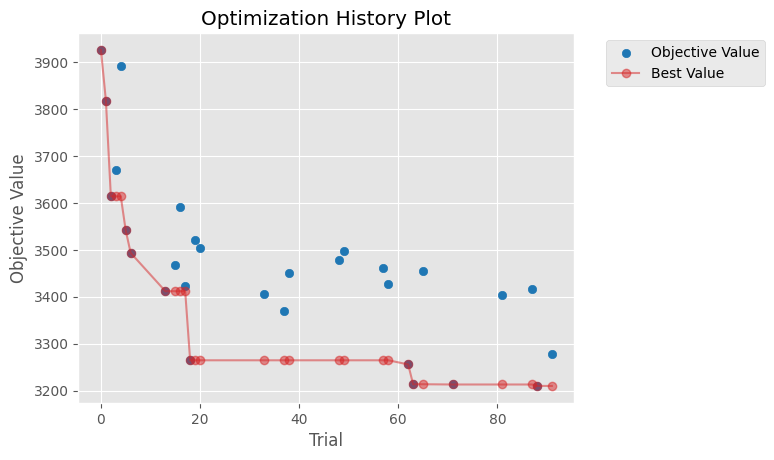

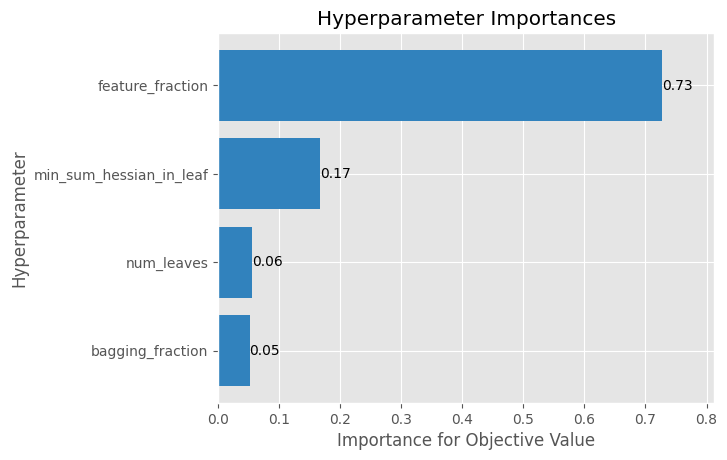

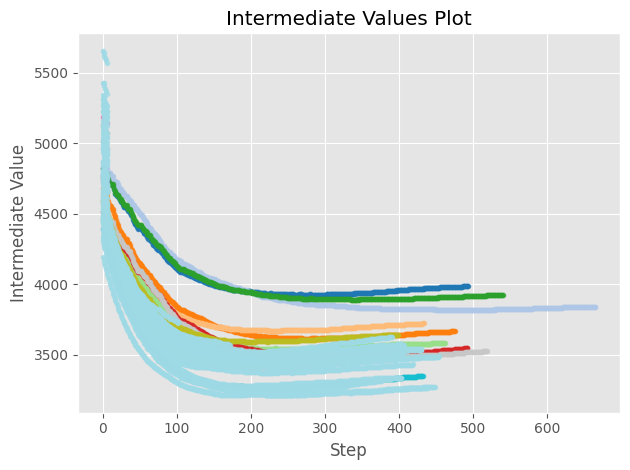

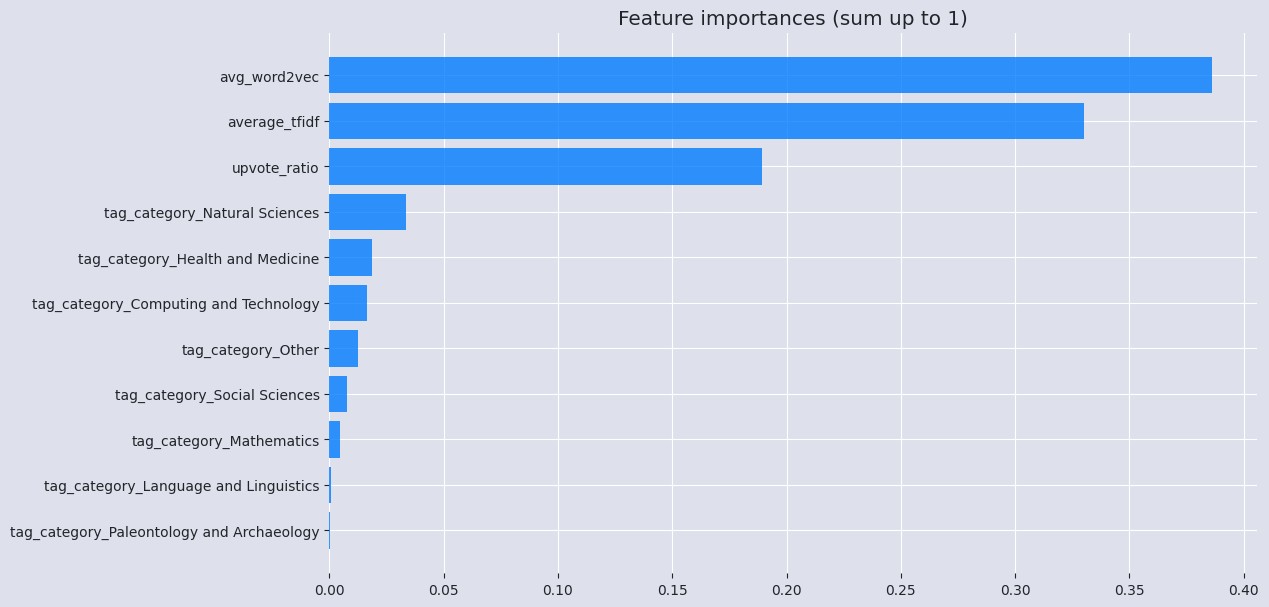


     . Optuna hyperparameters optimization finished
     .. Best trial number:88    |     rmse:            3210.153590447247
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 45.74887 seconds


RMSE: 4968.221403546391
MAE: 2409.0576687419752
R2: 0.2832069399042173


In [77]:
# baseline just embeddings and category, upvote ratio

from verstack import LGBMTuner

train_baseline = X_train[["average_tfidf", "avg_word2vec",  "upvote_ratio",'tag_category_Computing and Technology',
       'tag_category_Health and Medicine',
       'tag_category_Language and Linguistics', 'tag_category_Mathematics',
       'tag_category_Natural Sciences', 'tag_category_Other',
       'tag_category_Paleontology and Archaeology',
       'tag_category_Social Sciences']]
test_baseline = X_test[["average_tfidf", "avg_word2vec",  "upvote_ratio",'tag_category_Computing and Technology',
       'tag_category_Health and Medicine',
       'tag_category_Language and Linguistics', 'tag_category_Mathematics',
       'tag_category_Natural Sciences', 'tag_category_Other',
       'tag_category_Paleontology and Archaeology',
       'tag_category_Social Sciences']]




tuner = LGBMTuner(metric = 'rmse') # <- the only required argument
tuner.fit(train_baseline, y_train)

pred = tuner.predict(test_baseline)
# plot predictions vs actual

fig = px.scatter(x=y_test, y=pred, trendline='ols')
fig.update_layout(title='Predictions vs. Actual',
                   xaxis_title="Actual",
                   yaxis_title="Predicted")

fig.show()

print(f"RMSE: {mean_squared_error(y_test, pred, squared=False)}")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"R2: {r2_score(y_test, pred)}")


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 3895.480859815283
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 3330.1132881509407
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 4445.475692476755
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 3849.230524475213
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 4011.999413055508
 ..................................................

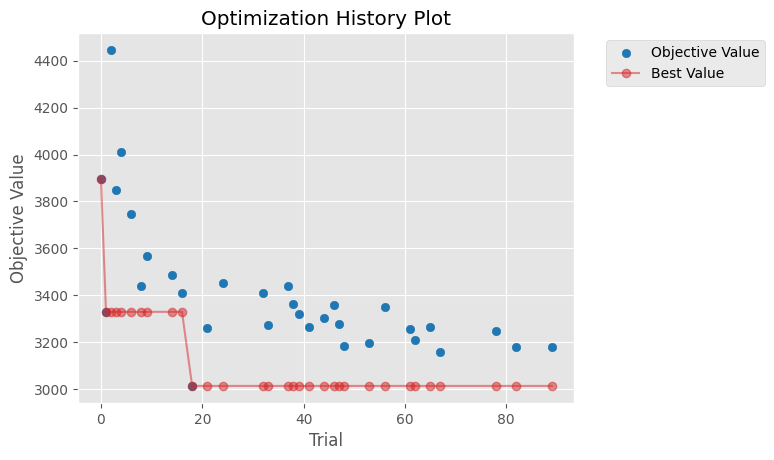

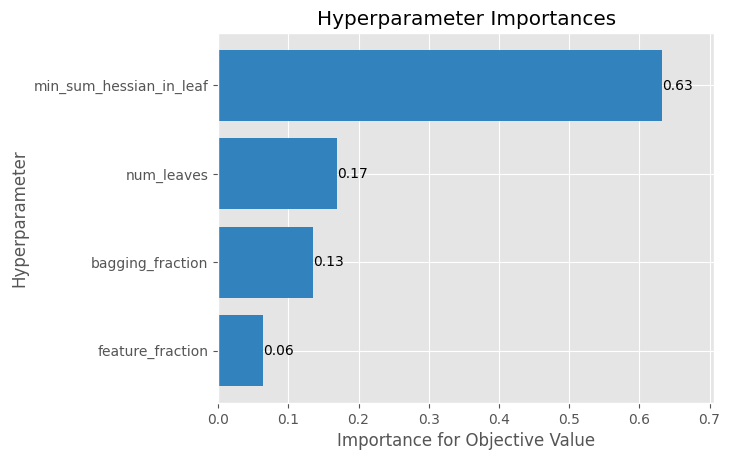

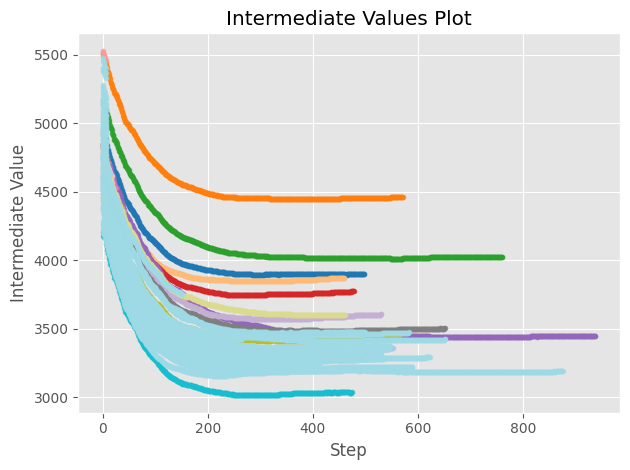

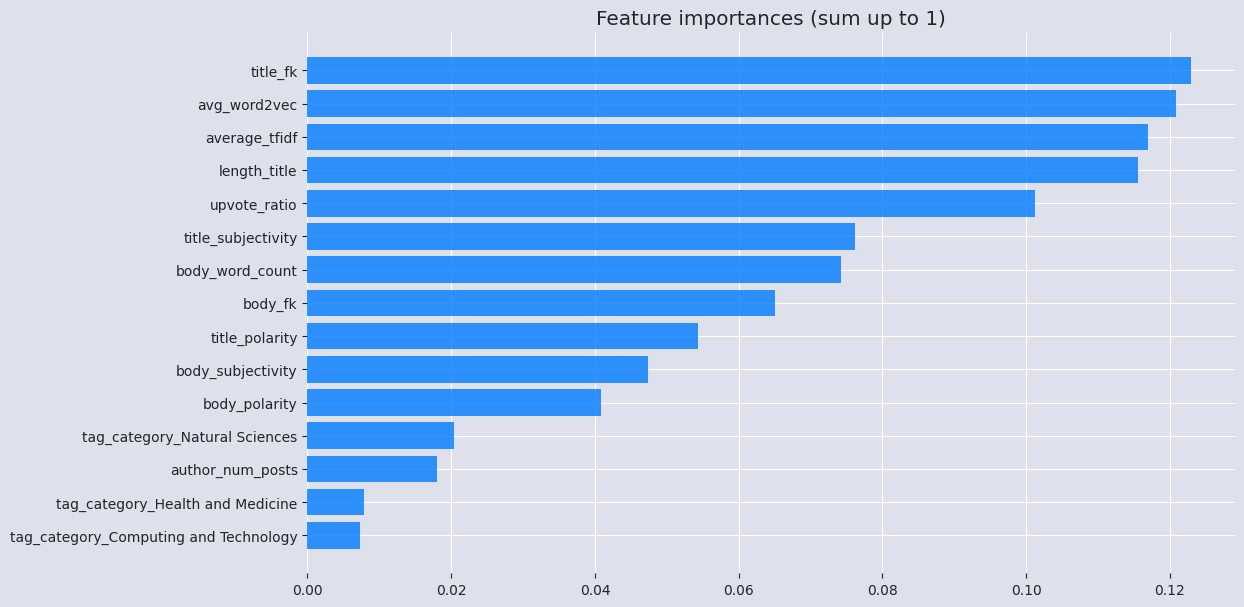


     . Optuna hyperparameters optimization finished
     .. Best trial number:18    |     rmse:           3014.5962436669083
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 3 min 7.452 sec


RMSE: 4818.877095442745
MAE: 2338.9132391525304
R2: 0.3256527222996819


In [72]:
cols = ['score', 'upvote_ratio','tag_category', 'author_num_posts', 'empty_body', 'body_polarity',
       'body_subjectivity', 'body_word_count', 'length_title',
       'title_polarity', 'title_subjectivity', 'title_fk', 'body_fk',
       'average_tfidf', 'avg_word2vec']

verstack_df = df[cols]
verstack_df = pd.get_dummies(verstack_df, columns=['tag_category'])

verstack_X = verstack_df.drop(columns=['score'])


X_train, X_test, y_train, y_test = train_test_split(verstack_X, verstack_df['score'], test_size=0.33, random_state=42)


tuner = LGBMTuner(metric = 'rmse')
tuner.fit(X_train, y_train)

pred = tuner.predict(X_test)
# plot predictions vs actual

fig = px.scatter(x=y_test, y=pred, trendline='ols')
fig.update_layout(title='Predictions vs. Actual',
                   xaxis_title="Actual",
                   yaxis_title="Predicted")

fig.show()

print(f"RMSE: {mean_squared_error(y_test, pred, squared=False)}")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"R2: {r2_score(y_test, pred)}")

In [69]:
X_train

score  upvote_ratio  author_num_posts  empty_body  body_polarity  \
1206     7.0          0.67                 1           0       0.000000   
509   8707.0          0.95                 1           1       0.000000   
597   8173.0          0.91                 1           1       0.000000   
1587     9.0          0.61                 1           0      -0.059821   
981   6335.0          0.91                 1           0       0.000000   
...      ...           ...               ...         ...            ...   
1130     4.0          0.71                 1           0       0.114286   
1294    30.0          0.82                 1           0       0.081771   
860   6758.0          0.92                 1           0       0.050000   
4003     6.0          0.88                 1           0       0.083333   
3669     6.0          0.75                 1           0       0.009091   

      body_subjectivity  body_word_count  length_title  title_polarity  \
1206           0.000000                1            21        0.000000   
509            0.000000                0            23       -0.225000   
597            0.000000                0             9        0.068182   
1587           0.577266               53            12        0.000000   
981            0.000000                7            17        0.000000   
...                 ...              ...           ...             ...   
1130           0.448413              138             5        0.000000   
1294           0.483854              175            14        0.400000   
860            0.150000               16            16        0.250000   
4003           0.216667               34            13        0.000000   
3669           0.625000               54            14        0.000000   

      title_subjectivity  ...  average_tfidf  avg_word2vec  \
1206            0.000000  ...       0.000338      0.014828   
509             0.458333  ...       0.000243      0.007477   
597             0.477273  ...       0.000167      0.005403   
1587            0.000000  ...       0.000370     -0.012820   
981             0.000000  ...       0.000268      0.016728   
...                  ...  ...            ...           ...   
1130            0.000000  ...       0.000572      0.001211   
1294            0.800000  ...       0.000513     -0.009473   
860             0.300000  ...       0.000278      0.017040   
4003            0.000000  ...       0.000273     -0.012084   
3669            0.000000  ...       0.000337      0.016237   

      tag_category_Computing and Technology  tag_category_Health and Medicine  \
1206                                      0                                 0   
509                                       0                                 1   
597                                       0                                 0   
1587                                      0                                 1   
981                                       0                                 1   
...                                     ...                               ...   
1130                                      0                                 1   
1294                                      0                                 0   
860                                       0                                 0   
4003                                      0                                 0   
3669                                      0                                 0   

      tag_category_Language and Linguistics  tag_category_Mathematics  \
1206                                      0                         0   
509                                       0                         0   
597                                       0                         1   
1587                                      0                         0   
981                                       0                         0   
...                                     ...                  

In an unsurprisng fashion, upvote_ratio is the primary feature of Score. This makes sense as they are correlated and intuitivley makes sense. Next we see the title length, the vectorized numbers given they are the same we can drop one, likely word2vec. Then we see title FK score, and title subjectivity,which also make a lot fo sense as title would be important to generating clicks and upvotes.

In the graph above, we see that performance is not great but the model has captured the general direction. But with a low R2 score and RMSE around 4800 I would like to see further improvements. However, the features generated have increased the how predictive the model is so I will keep them for the next models.

# autoML

given the time constraints of the analysis and wanting to show my general process I will use autoML to see if we can get a better model. I will use the same features as above and see if we can get a better model. As autogluon has some great features around utilizing combinations of models and ensembling them.

In [ ]:
predictor = TabularPredictor(label='score').fit(train_data, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230928_044255/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230928_044255/"
AutoGluon Version:  0.8.2
Python Version:     3.10.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #48-Ubuntu SMP Tue Jun 20 20:34:08 UTC 2023
Disk Space Avail:   12.56 GB / 33.64 GB (37.3%)
Train Data Rows:    2483
Train Data Columns: 21
Label Column: score
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (51927.0, 0.0, 2749.18123, 4791.34757)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['

In [ ]:
pred = predictor.predict(test_data)
pred

0        875.366028
1       2142.653076
2         71.005737
3       8029.833984
4       7700.378906
           ...     
1219    7426.604980
1220    7717.554199
1221    4259.628418
1222    2193.680176
1223    6989.853027
Name: score, Length: 1224, dtype: float32

In [ ]:
print("MSE: ", mean_squared_error(test_data['score'], pred))
print("MAE: ", mean_absolute_error(test_data['score'], pred))
print("R2: ", r2_score(test_data['score'], pred))
print("RMSE: ", mean_squared_error(test_data['score'], pred, squared=False))

MSE:  22370853.617867813
MAE:  2067.806515170955
R2:  0.35035744612822606
RMSE:  4729.78367558896


In [ ]:
predictor.leaderboard(test_data, silent=True)

model   score_test    score_val  pred_time_test  \
0     ExtraTreesMSE_BAG_L2 -4721.565825 -3571.425134        1.383696   
1      WeightedEnsemble_L3 -4729.783676 -3521.240401        1.869831   
2      WeightedEnsemble_L2 -4730.760035 -3532.956112        0.885236   
3          CatBoost_BAG_L2 -4731.820429 -3532.839272        1.309689   
4          CatBoost_BAG_L1 -4734.226245 -3550.317038        0.036679   
5        LightGBMXT_BAG_L1 -4740.476724 -3623.370331        0.112521   
6     ExtraTreesMSE_BAG_L1 -4741.815345 -3624.569225        0.152294   
7        LightGBMXT_BAG_L2 -4746.735395 -3544.415591        1.356327   
8   NeuralNetFastAI_BAG_L2 -4752.502132 -3647.516632        1.450397   
9   RandomForestMSE_BAG_L1 -4776.593630 -3677.991995        0.125686   
10          XGBoost_BAG_L1 -4778.110405 -3761.779117        0.083915   
11  RandomForestMSE_BAG_L2 -4785.141104 -3639.306469        1.368131   
12         LightGBM_BAG_L2 -4787.489298 -3609.448260        1.305766   
13          XGBoost_BAG_L2 -4791.169607 -3645.288467        1.395077   
14         LightGBM_BAG_L1 -4812.364938 -3624.414036        0.056803   
15    LightGBMLarge_BAG_L1 -4815.889532 -3678.091370        0.263975   
16    LightGBMLarge_BAG_L2 -4832.010920 -3676.398975        1.374183   
17  NeuralNetFastAI_BAG_L1 -4872.958257 -3798.982291        0.245575   
18   NeuralNetTorch_BAG_L2 -4889.894766 -3668.853015        1.455132   
19   NeuralNetTorch_BAG_L1 -5681.374802 -4831.520226        0.157492   
20   KNeighborsDist_BAG_L1 -5795.062675 -4992.366137        0.013251   
21   KNeighborsUnif_BAG_L1 -5804.137178 -4916.769191        0.023991   

    pred_time_val    fit_time  pred_time_test_marginal  \
0        1.260752  162.432187                 0.111514   
1        1.682642  278.712285                 0.003316   
2        0.697568   90.990945                 0.004223   
3        1.061936  184.330977                 0.037508   
4        0.012892   18.718188                 0.036679   
5        0.117691   10.582837                 0.112521   
6        0.208025    1.441465                 0.152294   
7        1.108724  172.186018                 0.084145   
8        1.185570  196.933311                 0.178216   
9        0.187326    3.731454                 0.125686   
10       0.038248   14.036240                 0.083915   
11       1.216537  168.701178                 0.095949   
12       1.062953  173.299516                 0.033585   
13       1.109385  181.006729                 0.122896   
14       0.022976   10.846705                 0.056803   
15       0.073892   16.919477                 0.263975   
16       1.074836  182.757915                 0.102002   
17       0.192043   38.961038                 0.245575   
18       1.249013  204.603070                 0.182951   
19       0.126595   45.274639                 0.157492   
20       0.022065    0.005654                 0.013251   
21       0.044216    0.006043                 0.023991   

    pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0                 0.214783           1.908446            2       True   
1                 0.000525           0.321684            3       True   
2                 0.000415           0.372617            2       True   
3                 0.015967          23.807236            2       True   
4                 0.012892          18.718188            1       True   
5                 0.117691          10.582837            1       True   
6                 0.208025           1.441465            1       True   
7                 0.062755          11.662278            2       True   
8                 0.139601          36.409571            2       True   
9                 0.187326           3.731454            1       True   
10                0.038248          14.036240            1       True   
11                0.170568           8.177437            2       True   
12                0.016984          12.775776            2       True   
13     

We see an improved model. Given the similarity in scores between the model, it shows that it is likely with the current features the model cannot be greatly improved. What was very intereting to see is the tree based methods like te one I showed earlier are the key to making these predictions. This is likely due to the fact that the data is not linearly seperable and the tree based methods can capture the non linear relationships.

Given this information I will utilize the multimodal framework to see if utilizing some pretrained NLP techniques can improve the model. Beyond what I did with averages of the vectors.

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)
from sklearn.model_selection import train_test_split
from autogluon.multimodal import MultiModalPredictor
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

In [ ]:
mm_predictor = MultiModalPredictor(label='score').fit(train_data=train_df, presets='high_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230928_054902/"
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (51927.0, 0.0, 2692.63343, 4785.09897)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.2.

- Pytorch version is 1.13.1.

- Model will be saved to "/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902".

- Validation metric is "rmse".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_05

Epoch 0:  50%|████▉     | 187/375 [20:07<20:14,  6.46s/it, loss=1.73, v_num=]

Epoch 0, global step 7: 'val_rmse' reached 1.00606 (best 1.00606), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=0-step=7.ckpt' as top 3


Epoch 0: 100%|█████████▉| 374/375 [39:47<00:06,  6.38s/it, loss=1.13, v_num=] 

Epoch 0, global step 15: 'val_rmse' reached 1.02729 (best 1.00606), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=0-step=15.ckpt' as top 3


Epoch 1:  50%|████▉     | 187/375 [19:01<19:07,  6.10s/it, loss=0.789, v_num=]

Epoch 1, global step 23: 'val_rmse' reached 0.88139 (best 0.88139), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=1-step=23.ckpt' as top 3


Epoch 1: 100%|█████████▉| 374/375 [38:32<00:06,  6.18s/it, loss=1.94, v_num=] 

Epoch 1, global step 31: 'val_rmse' reached 0.85960 (best 0.85960), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=1-step=31.ckpt' as top 3


Epoch 2:  50%|████▉     | 187/375 [19:46<19:53,  6.35s/it, loss=0.588, v_num=]

Epoch 2, global step 39: 'val_rmse' reached 0.81306 (best 0.81306), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=2-step=39.ckpt' as top 3


Epoch 2: 100%|█████████▉| 374/375 [39:34<00:06,  6.35s/it, loss=0.509, v_num=]

Epoch 2, global step 47: 'val_rmse' reached 0.74350 (best 0.74350), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=2-step=47.ckpt' as top 3


Epoch 3:  50%|████▉     | 187/375 [18:58<19:04,  6.09s/it, loss=0.481, v_num=]

Epoch 3, global step 55: 'val_rmse' reached 0.67003 (best 0.67003), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=3-step=55.ckpt' as top 3


Epoch 3: 100%|█████████▉| 374/375 [37:15<00:05,  5.98s/it, loss=0.44, v_num=] 

Epoch 3, global step 63: 'val_rmse' reached 0.78220 (best 0.67003), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=3-step=63.ckpt' as top 3


Epoch 4:  50%|████▉     | 187/375 [17:14<17:20,  5.53s/it, loss=0.401, v_num=]

Epoch 4, global step 71: 'val_rmse' reached 0.65187 (best 0.65187), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=4-step=71.ckpt' as top 3


Epoch 4: 100%|█████████▉| 374/375 [34:52<00:05,  5.60s/it, loss=0.288, v_num=]

Epoch 4, global step 79: 'val_rmse' reached 0.57707 (best 0.57707), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=4-step=79.ckpt' as top 3


Epoch 5:  50%|████▉     | 187/375 [16:54<17:00,  5.43s/it, loss=0.416, v_num=]

Epoch 5, global step 87: 'val_rmse' reached 0.56024 (best 0.56024), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=5-step=87.ckpt' as top 3


Epoch 5: 100%|█████████▉| 374/375 [34:31<00:05,  5.54s/it, loss=0.45, v_num=] 

Epoch 5, global step 95: 'val_rmse' reached 0.56088 (best 0.56024), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=5-step=95.ckpt' as top 3


Epoch 6:  50%|████▉     | 187/375 [17:14<17:20,  5.53s/it, loss=0.529, v_num=]

Epoch 6, global step 103: 'val_rmse' reached 0.56138 (best 0.56024), saving model to '/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902/epoch=6-step=103.ckpt' as top 3


Epoch 6: 100%|█████████▉| 374/375 [34:05<00:05,  5.47s/it, loss=0.308, v_num=]

Epoch 6, global step 111: 'val_rmse' was not in top 3


Epoch 7:  50%|████▉     | 187/375 [17:01<17:06,  5.46s/it, loss=0.405, v_num=]

Epoch 7, global step 119: 'val_rmse' was not in top 3


Epoch 7: 100%|█████████▉| 374/375 [34:01<00:05,  5.46s/it, loss=0.414, v_num=]

Epoch 7, global step 127: 'val_rmse' was not in top 3


Epoch 8:  50%|████▉     | 187/375 [16:52<16:58,  5.42s/it, loss=0.208, v_num=]

Epoch 8, global step 135: 'val_rmse' was not in top 3


Epoch 8: 100%|█████████▉| 374/375 [33:44<00:05,  5.41s/it, loss=0.174, v_num=]

Epoch 8, global step 143: 'val_rmse' was not in top 3


Epoch 9:  50%|████▉     | 187/375 [17:12<17:17,  5.52s/it, loss=0.184, v_num=]

Epoch 9, global step 151: 'val_rmse' was not in top 3


Epoch 9: 100%|█████████▉| 374/375 [34:28<00:05,  5.53s/it, loss=0.965, v_num=]

Epoch 9, global step 159: 'val_rmse' was not in top 3


Epoch 9: 100%|██████████| 375/375 [34:31<00:00,  5.52s/it, loss=0.526, v_num=]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 375/375 [34:31<00:00,  5.52s/it, loss=0.526, v_num=]


Start to fuse 3 checkpoints via the greedy soup algorithm.
/Users/ryanlee/miniconda3/envs/autogluon/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 16/16 [02:13<00:00,  8.33s/it]


/Users/ryanlee/miniconda3/envs/autogluon/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 16/16 [02:19<00:00,  8.70s/it]


/Users/ryanlee/miniconda3/envs/autogluon/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 16/16 [02:20<00:00,  8.76s/it]


AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /Users/ryanlee/Developer/Ryan_takehome-main/AutogluonModels/ag-20230928_054902
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




In [ ]:
predictions = mm_predictor.predict(test_df)


/Users/ryanlee/miniconda3/envs/autogluon/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 39/39 [05:20<00:00,  8.22s/it]


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


print("Mean squared error: %.2f" % mean_squared_error(test_df['score'], predictions))
print("Mean absolute error: %.2f" % mean_absolute_error(test_df['score'], predictions))
print('R2 score: %.2f' % r2_score(test_df['score'], predictions))


Mean squared error: 14541470.09
Mean absolute error: 1548.52
R2 score: 0.58


In [ ]:
import plotly.express as px
px.scatter(x=test_df['score'], y=predictions, trendline="ols")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/ryanlee/miniconda3/envs/autogluon/lib/python3.10/site-packages/IPython/core/formatters.py │
│ :223 in catch_format_error                                                                       │
│                                                                                                  │
│    220 def catch_format_error(method, self, *args, **kwargs):                                    │
│    221 │   """show traceback on failed format call"""                                            │
│    222 │   try:                                                                                  │
│ ❱  223 │   │   r = method(self, *args, **kwargs)                                                 │
│    224 │   except NotImplementedError:                                                           │
│    225 │   │   # don't warn on NotImplementedErrors                                              │
│    226 │   │   return self._check_return(None, args[0])                                          │
│                                                                                                  │
│ /Users/ryanlee/miniconda3/envs/autogluon/lib/python3.10/site-packages/IPython/core/formatters.py │
│ :922 in __call__                                                                                 │
│                                                                                                  │
│    919 │   │   │   # Finally look for special method names                                       │
│    920 │   │   │   method = get_real_method(obj, self.print_method)                              │
│    921 │   │   │   if method is not None:                                                        │
│ ❱  922 │   │   │   │   method()                                                                  │
│    923 │   │   │   │   return True                                                               │
│    924                                                                                           │
│    925                                                                                           │
│                                                                                                  │
│ /Users/ryanlee/miniconda3/envs/autogluon/lib/python3.10/site-packages/plotly/basedatatypes.py:83 │
│ 4 in _ipython_display_                                                                           │
│                                                                                                  │
│    831 │   │   import plotly.io as pio                                                           │
│    832 │   │                                                                                     │
│    833 │   │   if pio.renderers.render_on_display and pio.renderers.default:                     │
│ ❱  834 │   │   │   pio.show(self)                                                                │
│    835 │   │   else:                                                                             │
│    836 │   │   │   print(repr(self))                                                             │
│    837                                                                                           │
│                                                                                                  │
│ /Users/ryanlee/miniconda3/envs/autogluon/lib/python3.10/site-packages/plotly/io/_renderers.py:39 │
│ 6 in show                                                                                        │
│                                                                                                  │
│   393 │   │   │   )                                                                              │
│   394 │   │                                                                                      │
│   395 │   │   if not nbformat or Version(nbformat.__version

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array([16., 31.,  0., ..., 88., 61., 10.]),
              'xaxis': 'x',
              'y': array([ 615.954  ,  532.83606,  537.944  , ..., 1364.1812 ,  489.13855,
                           549.1    ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': ('<b>OLS trendline</b><br>y = 0.' ... ' <b>(trend)</b><extra></extra>'),
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array([    0.,     0.,     0., ..., 37681., 65835., 83382.]),
              'xaxis': 'x',
              'y': array([ 1269.64556218,  1269.64556218,  1269.64556218, ..., 21771.73065042,
                          37090.21220809, 46637.46644878]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y'}}}
})

Here we see a large improvement in model performance, this model is more of a black box on what was important or the decisions/weights that it assigned, however we see a clear impact as a result. The predictions around 10K are more accurate then previous models. This methodology demonstrates the power of autoML and how there is more optimization with other pretrained model techniques that can be done. Next we will try to implement this ourself.

# Multimodal Neural Network

# Neural network

As autoML is fascinating and a great tool, one last attempt to improve the model will be to use cuatom multimodal model utilizing distilbert as this is a smaller model to start from. Additionally, 

In [59]:
numeric_cols = ['upvote_ratio',
        'author_num_posts', 'empty_body',
       'body_polarity', 'body_subjectivity', 'body_word_count', 'length_title',
       'title_polarity', 'title_subjectivity', 'title_fk', 'body_fk', 'tag_category_Computing and Technology',
       'tag_category_Health and Medicine',
       'tag_category_Language and Linguistics', 'tag_category_Mathematics',
       'tag_category_Natural Sciences', 'tag_category_Other',
       'tag_category_Paleontology and Archaeology',
       'tag_category_Social Sciences']

In [61]:
# neural network approach


df = pd.get_dummies(df, columns=['tag_category'])
X_text = df[['text']] 
X_numeric = df[numeric_cols]

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
input_ids = tokenizer(X_text['text'].tolist(), return_tensors='pt', padding=True, truncation=True)
nlp_input = input_ids['input_ids']

scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)

y_score = df['score']

X_text_train, X_text_test, X_numeric_train, X_numeric_test, y_score_train, y_score_test = train_test_split(
    nlp_input, X_numeric, y_score, test_size=0.33, random_state=42
)



In [62]:
# # Load DistilBERT model
# 

# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# # Tokenize and convert text data
# input_ids = tokenizer(X_text_train.tolist(), return_tensors='pt', padding=True, truncation=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│   5 distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')                │
│   6                                                                                              │
│   7 # Tokenize and convert text data                                                             │
│ ❱ 8 input_ids = tokenizer(X_text_train.tolist(), return_tensors='pt', padding=True, truncati     │
│   9                                                                                              │
│                                                                                                  │
│ /Users/ryanlee/opt/miniconda3/envs/pivotal_test2/lib/python3.8/site-packages/transformers/tokeni │
│ zation_utils_base.py:2523 in __call__                                                            │
│                                                                                                  │
│   2520 │   │   │   # input mode in this case.                                                    │
│   2521 │   │   │   if not self._in_target_context_manager:                                       │
│   2522 │   │   │   │   self._switch_to_input_mode()                                              │
│ ❱ 2523 │   │   │   encodings = self._call_one(text=text, text_pair=text_pair, **all_kwargs)      │
│   2524 │   │   if text_target is not None:                                                       │
│   2525 │   │   │   self._switch_to_target_mode()                                                 │
│   2526 │   │   │   target_encodings = self._call_one(text=text_target, text_pair=text_pair_targ  │
│                                                                                                  │
│ /Users/ryanlee/opt/miniconda3/envs/pivotal_test2/lib/python3.8/site-packages/transformers/tokeni │
│ zation_utils_base.py:2581 in _call_one                                                           │
│                                                                                                  │
│   2578 │   │   │   │   return False                                                              │
│   2579 │   │                                                                                     │
│   2580 │   │   if not _is_valid_text_input(text):                                                │
│ ❱ 2581 │   │   │   raise ValueError(                                                             │
│   2582 │   │   │   │   "text input must of type `str` (single example), `List[str]` (batch or s  │
│   2583 │   │   │   │   "or `List[List[str]]` (batch of pretokenized examples)."                  │
│   2584 │   │   │   )                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or 
`List[List[str]]` (batch of pretokenized examples).

In [69]:
# Assuming X_text_train is a DataFrame column
X_text_train = X_text_train['body'].tolist()

# Tokenize and convert text data
input_ids = tokenizer(X_text_train, return_tensors='pt', padding=True, truncation=True)
nlp_input_train = input_ids['input_ids']


In [63]:
# Define the DistilBERT model
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
outputs = distilbert_model(**input_ids)
nlp_output_train = outputs.last_hidden_state.mean(dim=1)

# Define a Dense layer for numeric data
numeric_input = tf.keras.layers.Input(shape=(X_numeric_train.shape[1],))
numeric_dense = Dense(64, activation='relu')(numeric_input)

# Concatenate NLP and numeric features
concatenated = Concatenate()([nlp_output_train, numeric_dense])

# Add additional layers if needed
dense_layer = Dense(32, activation='relu')(concatenated)

# Output layer for score prediction
output = Dense(1, activation='linear')(dense_layer)

# Define the model
model = tf.keras.models.Model(inputs=[numeric_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit([X_numeric_train], y_score_train, epochs=10, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate([X_numeric_test], y_score_test)

# Predict 'score' using the trained model
predictions = model.predict([X_numeric_test])


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


: 

In [2]:
predictions

NameError: name 'predictions' is not defined


Failed due kernel crashing, local compute power does not seem able to handle the model.


# Conclusion

In conclusion, feature engineering is impactful for modeling as we see the baseline + ratio + reworked tag, we saw the model performance at R2: 0.28 and after feature engineering and optimizing for model type the best score produces was an R2: 0.58. I am using R2 over RMSE because it is more easily interpretable in this document.

The feature engineering that was created added predictive value to model, and as we saw earlier in the document with the feature importanve graph, were not the top features but as we saw in the score, they had a net positive impact on the model.

Unfortunatley, I dont have the compute locally to run the final model, I would have like to see the performance of the multimodal model whislt utilizing distilbert with the numeric features I created. I think the performance would have been similar to the autoML model, but we would have been able to look at the model and its feature importances utilizing SHAP and assess the model in a more interpretable way.
